# Distributing Tensorflow Across Devices and Servers.
### Multi-Worker Training with Keras
- Multi-Worker  Configuration - this approach uses IP addresses/ports
- Chief worker takes on more work like saving checkpoint and writing file summary for Tensorboard
- Chief worker takes index 0.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow_datasets as tfds
import tensorflow as tf
import json, os

tfds.disable_progress_bar()

os.environ["TF_CONFIG"] = json.dumps(
    {
        "cluster": {"worker": ["localhost:12345", ]}, #"localhost:23456"]},
        "task": {"type": "worker", "index": 0},
    }
)
strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()
buffer_size = 10000
batch_size = 64


def make_datasets_unbatched():
    # Scaling MNIST data from (0, 255] to (0., 1.]
    def scale(image, label):
        image = tf.cast(image, tf.float32)
        image /= 255
        return image, label

    datasets, info = tfds.load(name="mnist", with_info=True, as_supervised=True)

    return datasets["train"].map(scale).cache().shuffle(buffer_size)


train_datasets = make_datasets_unbatched().batch(batch_size)

INFO:tensorflow:Enabled multi-worker collective ops with available devices: ['/job:worker/replica:0/task:0/device:CPU:0']
INFO:tensorflow:Using MirroredStrategy with devices ('/job:worker/task:0',)
INFO:tensorflow:MultiWorkerMirroredStrategy with cluster_spec = {'worker': ['localhost:12345']}, task_type = 'worker', task_id = 0, num_workers = 1, local_devices = ('/job:worker/task:0',), communication = CollectiveCommunication.AUTO


In [2]:
def build_and_compile_cnn_model():
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(32, 3, activation="relu", input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(10, activation="softmax"),
        ]
    )
    model.compile(
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
        metrics=["accuracy"],
    )
    return model

In [3]:
# CollectiveCommunication - AUTO: Default to runtime's automatic choices,RING: TensorFlow's ring algorithms for all-reduce and 
#all-gather and NCCL: Use ncclAllReduce for all-reduce, and ring algorithms for all-gather.
#You should expect to see the loss dropping and accuracy approaching 1.0 as epoch advances.

num_workers = 1
global_batch_size = 64 * num_workers
with strategy.scope():
    train_datasets = make_datasets_unbatched().batch(global_batch_size)
    multi_worker_model = build_and_compile_cnn_model()
multi_worker_model.fit(x=train_datasets, epochs=3, steps_per_epoch=5)

Train for 5 steps
Epoch 1/3
5/5 [==============================] - 2s 396ms/step - loss: 2.2997 - accuracy: 0.1063
Epoch 2/3
5/5 [==============================] - 0s 32ms/step - loss: 2.3012 - accuracy: 0.0875
Epoch 3/3
5/5 [==============================] - 0s 28ms/step - loss: 2.2945 - accuracy: 0.1031


In [4]:
#In multi-worker training, sharding data into multiple parts is needed to ensure convergence and performance.
# Manual auto Sharding can be turned off with this function.

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
train_dataset_no_auto_shard = train_datasets.with_options(options)

In [5]:
checkpoint_dir = './Multi_worker_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'Multi_worker_{epoch}')
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True),]

with strategy.scope():
    multi_worker_model = build_and_compile_cnn_model()
multi_worker_model.fit(x=train_datasets, epochs=3, steps_per_epoch=5, callbacks=callbacks)

Train for 5 steps
Epoch 1/3
5/5 [==============================] - 4s 756ms/step - loss: 2.3139 - accuracy: 0.0969
Epoch 2/3
5/5 [==============================] - 0s 41ms/step - loss: 2.3045 - accuracy: 0.1156
Epoch 3/3
5/5 [==============================] - 0s 37ms/step - loss: 2.3076 - accuracy: 0.1063


In [6]:
!dir {'Multi_worker_checkpoints'}

 Volume in drive C is Windows 10
 Volume Serial Number is E4B6-0ECA

 Directory of C:\Users\User\TensorFlow_1\Multi_worker_checkpoints

02/25/2020  05:36 PM    <DIR>          .
02/25/2020  05:36 PM    <DIR>          ..
02/25/2020  05:36 PM                85 checkpoint
02/25/2020  05:36 PM         1,389,634 Multi_worker_1.data-00000-of-00001
02/25/2020  05:36 PM               740 Multi_worker_1.index
02/25/2020  05:36 PM         1,389,634 Multi_worker_2.data-00000-of-00001
02/25/2020  05:36 PM               740 Multi_worker_2.index
02/25/2020  05:36 PM         1,389,634 Multi_worker_3.data-00000-of-00001
02/25/2020  05:36 PM               740 Multi_worker_3.index
               7 File(s)      4,171,207 bytes
               2 Dir(s)  24,354,209,792 bytes free


# Multi-Worker Training with Estimators

In [7]:
# Input Function
buffer_size = 10000
batch_size = 64

def input_fn(mode, input_context=None):
    datasets, info = tfds.load(name='mnist', with_info=True, as_supervised=True)
    mnist_dataset = (datasets['train']if mode == tf.estimator.ModeKeys.TRAIN else
                    dataset['tests'])                                               #Training/fitting mode.
    def scale(image, label):
        image = tf.cast(image, tf.float32)
        image /= 255
        return image, label
    
    if input_context:
        mnist_dataset = mnist_dataset.shard(input_context.num_input_pipelines,
                                           input_context.input_pipeline_id)
        return mnist_dataset.map(scale).cache().shuffle(buffer_size).batch(batch_size)

In [8]:
# Multi-Worker Configuration.
os.environ['TF_CONFIG'] = json.dumps({
    'cluster' : {
        'worker' : ['localhost:12345']#, 'localhost:23456']
    },
    'task' : {'type' : 'worker', 'index' : 0}
})

In [9]:
#Define the model
learning_rate = 0.0001
def model_fn(features, labels, mode):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation = 'relu', input_shape=(28,28,1)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(10)
    ])
    logits = model(features, training=False)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {'logits' : logits}
        return tf.estimator.EstimatorSpec(labels=labels, predictions=predictions) #Predication/inference mode.
    
    #optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                    reduction = tf.keras.losses.Reduction.NONE)(labels, logits)
    loss = tf.reduce_sum(loss) * 1./batch_size
    
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(mode, loss=loss)                        #Testing/evaluation mode.
    
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss,
                                      train_op = optimizer.minimize(loss, tf.compat.v1.train.get_or_create_global_step()))

In [10]:
#MultiWorkerMirroredStrategy which uses CollectiveOps which aggregates gradients  and keep variables in sync.
#To override the automatic choice, commmunication=tf.distribute.exerimental.CollectiveCommunication.NCCL can be used
#Or any other collective communication implementations like RING.

strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Enabled multi-worker collective ops with available devices: ['/job:worker/replica:0/task:0/device:CPU:0']


INFO:tensorflow:Enabled multi-worker collective ops with available devices: ['/job:worker/replica:0/task:0/device:CPU:0']


INFO:tensorflow:Using MirroredStrategy with devices ('/job:worker/task:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:worker/task:0',)


INFO:tensorflow:MultiWorkerMirroredStrategy with cluster_spec = {'worker': ['localhost:12345']}, task_type = 'worker', task_id = 0, num_workers = 1, local_devices = ('/job:worker/task:0',), communication = CollectiveCommunication.AUTO


INFO:tensorflow:MultiWorkerMirroredStrategy with cluster_spec = {'worker': ['localhost:12345']}, task_type = 'worker', task_id = 0, num_workers = 1, local_devices = ('/job:worker/task:0',), communication = CollectiveCommunication.AUTO


Number of devices: 1


In [11]:
#Train and evaluate the model

config = tf.estimator.RunConfig(train_distribute=strategy)
classifier = tf.estimator.Estimator(model_fn=model_fn, model_dir='/tmp/estimator_worker',config=config)
tf.estimator.train_and_evaluate(classifier,
                               train_spec = tf.estimator.TrainSpec(input_fn=input_fn),
                               eval_spec = tf.estimator.EvalSpec(input_fn=input_fn)
                               )

INFO:tensorflow:TF_CONFIG environment variable: {'cluster': {'worker': ['localhost:12345']}, 'task': {'type': 'worker', 'index': 0}}


INFO:tensorflow:TF_CONFIG environment variable: {'cluster': {'worker': ['localhost:12345']}, 'task': {'type': 'worker', 'index': 0}}


INFO:tensorflow:Initializing RunConfig with distribution strategies.


INFO:tensorflow:Initializing RunConfig with distribution strategies.


INFO:tensorflow:RunConfig initialized for Distribute Coordinator with INDEPENDENT_WORKER mode


INFO:tensorflow:RunConfig initialized for Distribute Coordinator with INDEPENDENT_WORKER mode


INFO:tensorflow:Using config: {'_model_dir': '/tmp/estimator_worker', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': <tensorflow.python.distribute.collective_all_reduce_strategy.CollectiveAllReduceStrategy object at 0x000001FA8003A0C8>, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({'worker': ['localhost:12345']}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_distr

INFO:tensorflow:Using config: {'_model_dir': '/tmp/estimator_worker', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': <tensorflow.python.distribute.collective_all_reduce_strategy.CollectiveAllReduceStrategy object at 0x000001FA8003A0C8>, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({'worker': ['localhost:12345']}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_distr

INFO:tensorflow:Running `train_and_evaluate` with Distribute Coordinator.


INFO:tensorflow:Running `train_and_evaluate` with Distribute Coordinator.


INFO:tensorflow:Running Distribute Coordinator with mode = 'independent_worker', cluster_spec = {'worker': ['localhost:12345']}, task_type = 'worker', task_id = 0, environment = None, rpc_layer = 'grpc'


INFO:tensorflow:Running Distribute Coordinator with mode = 'independent_worker', cluster_spec = {'worker': ['localhost:12345']}, task_type = 'worker', task_id = 0, environment = None, rpc_layer = 'grpc'


INFO:tensorflow:Using MirroredStrategy with devices ('/job:worker/task:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:worker/task:0',)


INFO:tensorflow:MultiWorkerMirroredStrategy with cluster_spec = {'worker': ['localhost:12345']}, task_type = 'worker', task_id = 0, num_workers = 1, local_devices = ('/job:worker/task:0',), communication = CollectiveCommunication.AUTO


INFO:tensorflow:MultiWorkerMirroredStrategy with cluster_spec = {'worker': ['localhost:12345']}, task_type = 'worker', task_id = 0, num_workers = 1, local_devices = ('/job:worker/task:0',), communication = CollectiveCommunication.AUTO


INFO:tensorflow:Using MirroredStrategy with devices ('/job:worker/task:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:worker/task:0',)


INFO:tensorflow:MultiWorkerMirroredStrategy with cluster_spec = {'worker': ['localhost:12345']}, task_type = 'worker', task_id = 0, num_workers = 1, local_devices = ('/job:worker/task:0',), communication = CollectiveCommunication.AUTO


INFO:tensorflow:MultiWorkerMirroredStrategy with cluster_spec = {'worker': ['localhost:12345']}, task_type = 'worker', task_id = 0, num_workers = 1, local_devices = ('/job:worker/task:0',), communication = CollectiveCommunication.AUTO


INFO:tensorflow:Updated config: {'_model_dir': '/tmp/estimator_worker', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': <tensorflow.python.distribute.collective_all_reduce_strategy.CollectiveAllReduceStrategy object at 0x000001FA800384C8>, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({'worker': ['localhost:12345']}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://localhost:12345', '_evaluation_master': 'grpc://localhost:12345', '_is_chief': True, '_num_ps_re

INFO:tensorflow:Updated config: {'_model_dir': '/tmp/estimator_worker', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': <tensorflow.python.distribute.collective_all_reduce_strategy.CollectiveAllReduceStrategy object at 0x000001FA800384C8>, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({'worker': ['localhost:12345']}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://localhost:12345', '_evaluation_master': 'grpc://localhost:12345', '_is_chief': True, '_num_ps_re

INFO:tensorflow:The `input_fn` accepts an `input_context` which will be given by DistributionStrategy


INFO:tensorflow:The `input_fn` accepts an `input_context` which will be given by DistributionStrategy


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:all_hooks [<tensorflow_estimator.python.estimator.util.DistributedIteratorInitializerHook object at 0x000001FA80303908>, <tensorflow.python.training.basic_session_run_hooks.NanTensorHook object at 0x000001FA8078A788>, <tensorflow.python.training.basic_session_run_hooks.LoggingTensorHook object at 0x000001FAFAC42148>, <tensorflow.python.training.basic_session_run_hooks.StepCounterHook object at 0x000001FAFAC586C8>, <tensorflow.python.training.basic_session_run_hooks.SummarySaverHook object at 0x000001FA80783888>, <tensorflow.python.training.basic_session_run_hooks.CheckpointSaverHook object at 0x000001FAFAC23F48>]


INFO:tensorflow:all_hooks [<tensorflow_estimator.python.estimator.util.DistributedIteratorInitializerHook object at 0x000001FA80303908>, <tensorflow.python.training.basic_session_run_hooks.NanTensorHook object at 0x000001FA8078A788>, <tensorflow.python.training.basic_session_run_hooks.LoggingTensorHook object at 0x000001FAFAC42148>, <tensorflow.python.training.basic_session_run_hooks.StepCounterHook object at 0x000001FAFAC586C8>, <tensorflow.python.training.basic_session_run_hooks.SummarySaverHook object at 0x000001FA80783888>, <tensorflow.python.training.basic_session_run_hooks.CheckpointSaverHook object at 0x000001FAFAC23F48>]


INFO:tensorflow:Creating chief session creator with config: device_filters: "/job:worker/task:0"
allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
    scoped_allocator_optimization: ON
    scoped_allocator_opts {
      enable_op: "CollectiveReduce"
    }
  }
}
experimental {
  collective_group_leader: "/job:worker/replica:0/task:0"
}



INFO:tensorflow:Creating chief session creator with config: device_filters: "/job:worker/task:0"
allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
    scoped_allocator_optimization: ON
    scoped_allocator_opts {
      enable_op: "CollectiveReduce"
    }
  }
}
experimental {
  collective_group_leader: "/job:worker/replica:0/task:0"
}



INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/estimator_worker\model.ckpt-3752


INFO:tensorflow:Restoring parameters from /tmp/estimator_worker\model.ckpt-3752


Instructions for updating:
Use standard file utilities to get mtimes.


Instructions for updating:
Use standard file utilities to get mtimes.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 3752 into /tmp/estimator_worker\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3752 into /tmp/estimator_worker\model.ckpt.


INFO:tensorflow:loss = 2.181678, step = 3752


INFO:tensorflow:loss = 2.181678, step = 3752


INFO:tensorflow:loss = 2.1149712, step = 3852 (2.652 sec)


INFO:tensorflow:loss = 2.1149712, step = 3852 (2.652 sec)


INFO:tensorflow:global_step/sec: 37.7381


INFO:tensorflow:global_step/sec: 37.7381


INFO:tensorflow:loss = 2.1340897, step = 3952 (2.622 sec)


INFO:tensorflow:loss = 2.1340897, step = 3952 (2.622 sec)


INFO:tensorflow:global_step/sec: 38.1267


INFO:tensorflow:global_step/sec: 38.1267


INFO:tensorflow:loss = 2.148635, step = 4052 (2.651 sec)


INFO:tensorflow:loss = 2.148635, step = 4052 (2.651 sec)


INFO:tensorflow:global_step/sec: 37.7291


INFO:tensorflow:global_step/sec: 37.7291


INFO:tensorflow:loss = 2.1143517, step = 4152 (2.677 sec)


INFO:tensorflow:loss = 2.1143517, step = 4152 (2.677 sec)


INFO:tensorflow:global_step/sec: 37.2252


INFO:tensorflow:global_step/sec: 37.2252


INFO:tensorflow:loss = 2.1245933, step = 4252 (2.799 sec)


INFO:tensorflow:loss = 2.1245933, step = 4252 (2.799 sec)


INFO:tensorflow:global_step/sec: 35.8219


INFO:tensorflow:global_step/sec: 35.8219


INFO:tensorflow:loss = 2.1059713, step = 4352 (2.715 sec)


INFO:tensorflow:loss = 2.1059713, step = 4352 (2.715 sec)


INFO:tensorflow:global_step/sec: 36.8592


INFO:tensorflow:global_step/sec: 36.8592


INFO:tensorflow:loss = 2.1333532, step = 4452 (2.678 sec)


INFO:tensorflow:loss = 2.1333532, step = 4452 (2.678 sec)


INFO:tensorflow:global_step/sec: 37.3361


INFO:tensorflow:global_step/sec: 37.3361


INFO:tensorflow:loss = 2.092216, step = 4552 (2.565 sec)


INFO:tensorflow:loss = 2.092216, step = 4552 (2.565 sec)


INFO:tensorflow:global_step/sec: 38.954


INFO:tensorflow:global_step/sec: 38.954


INFO:tensorflow:loss = 2.1042356, step = 4652 (2.373 sec)


INFO:tensorflow:loss = 2.1042356, step = 4652 (2.373 sec)


INFO:tensorflow:global_step/sec: 42.1639


INFO:tensorflow:global_step/sec: 42.1639


INFO:tensorflow:Saving checkpoints for 4690 into /tmp/estimator_worker\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4690 into /tmp/estimator_worker\model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:Loss for final step: 1.0565909.


INFO:tensorflow:Loss for final step: 1.0565909.


# Load Images

In [12]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_image
import IPython.display as display
import PIL
from PIL import Image
import numpy as np

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

#Retrieve the images
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

In [14]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [15]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

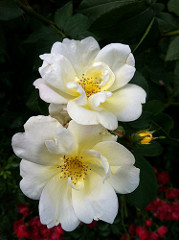

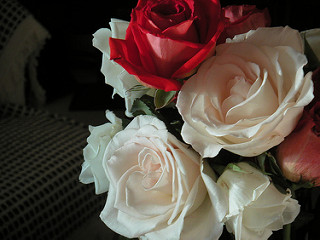

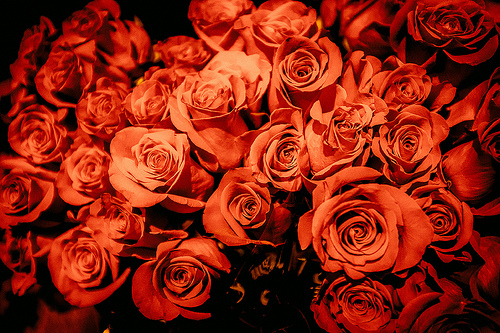

In [16]:
roses = list(data_dir.glob('roses/*'))
for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

In [17]:
#The 1./255 is to convert from uint8 to float32 in range 0 - 1.
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [18]:
batch_size = 32
img_height = 224
img_width = 224
steps_per_epoch = np.ceil(image_count / batch_size)

In [19]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),batch_size=batch_size,
                                                    shuffle = True,
                                                    target_size=(img_height, img_width),
                                                    classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


In [20]:
#Inspect a batch
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n] == 1][0].title())
        plt.axis('off')

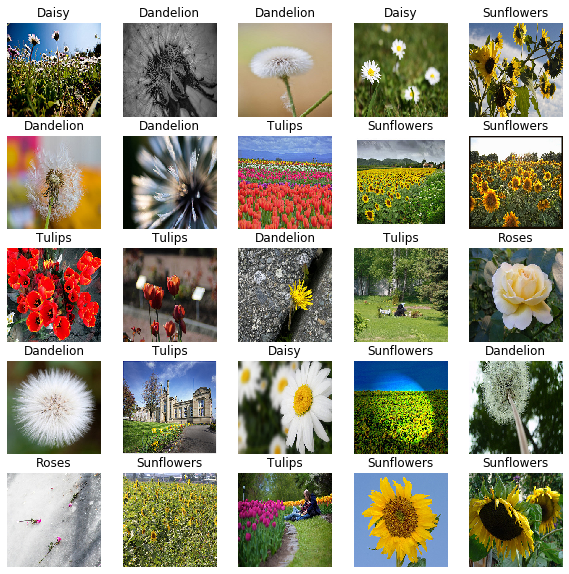

In [21]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [22]:
#Loading using tf.data

list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

for f in list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\User\\.keras\\datasets\\flower_photos\\daisy\\9180706736_092d43088c.jpg'
b'C:\\Users\\User\\.keras\\datasets\\flower_photos\\roses\\16152205512_9d6cb80fb6.jpg'
b'C:\\Users\\User\\.keras\\datasets\\flower_photos\\sunflowers\\3001533700_1c62fb8b4a_n.jpg'
b'C:\\Users\\User\\.keras\\datasets\\flower_photos\\sunflowers\\2720698862_486d3ec079_m.jpg'
b'C:\\Users\\User\\.keras\\datasets\\flower_photos\\daisy\\4318007511_e9f4311936_n.jpg'


In [23]:
#Convert the path to a list of path components
#The second to last is the class-directory

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == CLASS_NAMES

In [24]:
#Covert the compressed string to a 3D uint8 tensor
#Use convert_image_dtype to convert to floats in the 0 - 1 range.
#Resize the image to the desired size.

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [img_height, img_width])

In [25]:
#Load the raw data from the file as a string
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [26]:
#Using Dataset.map to create a datsetof image, label pairs.
#Set num_parallel_calls so multiple images are loaded/processed in parallel.

labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False False False  True False]


In [27]:
#Basic methods for training
#These features can be easily added using the tf.data api
#This is a small dataset which is only loaded once and kept in memory.
#Use cache to preprocessing work for datasets that don't fit in memory.

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
        
        #Repeart forever
        ds = ds.repeat()
        
        ds.batch(batch_size)
        
        #Prefetch lets the dataset fetch batches in the background while the model is training.
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        
        return ds

In [28]:
train_ds = prepare_for_training(labeled_ds)
image_batch, label_batch = next(iter(train_ds))

In [30]:
#show_batch(image_batch.numpy(), label_batch.numpy())

# Convolutional Neural Network(CNN)

In [32]:
from tensorflow.keras import datasets, layers, models

#Downloading and preparing the CIFAR10 dataset
#Normalize pixel values to be between 0 and 1
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

170500096/170498071 [==============================] - 129s 1us/step


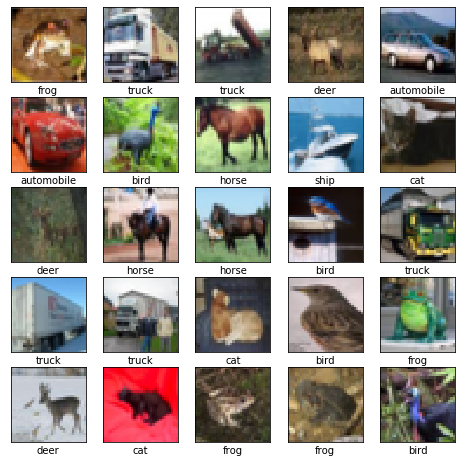

In [36]:
#The CIFAR labels happen to be arrays which is why you need the extra index.
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog','horse','ship','truck']
plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [39]:
#Create the convolutional base
#Maxpooling helps with shrinking of height and width.
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape=(32,32,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))

In [40]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


In [41]:
#Adding Dense layers on top
#Dense layers are vectors of 1D

model.add(layers.Flatten())
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(10))

In [42]:
#Complete Architecture of the model.
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [44]:
model.compile(optimizer='adam',
             loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics = ['accuracy'])

history = model.fit(train_images, train_labels, epochs = 10, validation_data = (test_images, test_labels))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 86s 2ms/sample - loss: 1.4995 - accuracy: 0.4560 - val_loss: 1.2491 - val_accuracy: 0.5558
Epoch 2/10
50000/50000 [==============================] - 93s 2ms/sample - loss: 1.1488 - accuracy: 0.5936 - val_loss: 1.0486 - val_accuracy: 0.6287
Epoch 3/10
50000/50000 [==============================] - 78s 2ms/sample - loss: 1.0063 - accuracy: 0.6484 - val_loss: 0.9657 - val_accuracy: 0.6599
Epoch 4/10
50000/50000 [==============================] - 81s 2ms/sample - loss: 0.9156 - accuracy: 0.6767 - val_loss: 0.9337 - val_accuracy: 0.6740
Epoch 5/10
50000/50000 [==============================] - 85s 2ms/sample - loss: 0.8446 - accuracy: 0.7032 - val_loss: 0.9252 - val_accuracy: 0.6784
Epoch 6/10
50000/50000 [==============================] - 82s 2ms/sample - loss: 0.7868 - accuracy: 0.7239 - val_loss: 0.8771 - val_accuracy: 0.6978
Epoch 7/10
50000/50000 [==============================] 

In [45]:
print('\nHistory Dict: ', history.history)


History Dict:  {'loss': [1.4995209401321412, 1.1488132307052612, 1.006310482234955, 0.9155668622970581, 0.8446384651947022, 0.7867980868721008, 0.7372651164054871, 0.6930572019481659, 0.6556593174743652, 0.6179198031139373], 'accuracy': [0.45596, 0.59362, 0.64836, 0.6767, 0.70322, 0.7239, 0.74084, 0.75726, 0.76904, 0.78296], 'val_loss': [1.249054341506958, 1.0486415075302125, 0.965692168045044, 0.9336946935653686, 0.9252104951858521, 0.877104547214508, 0.8655054233551025, 0.9130557643890381, 0.8657061757087707, 0.8716748604774475], 'val_accuracy': [0.5558, 0.6287, 0.6599, 0.674, 0.6784, 0.6978, 0.7058, 0.6913, 0.7091, 0.7067]}


10000/10000 - 4s - loss: 0.8717 - accuracy: 0.7067


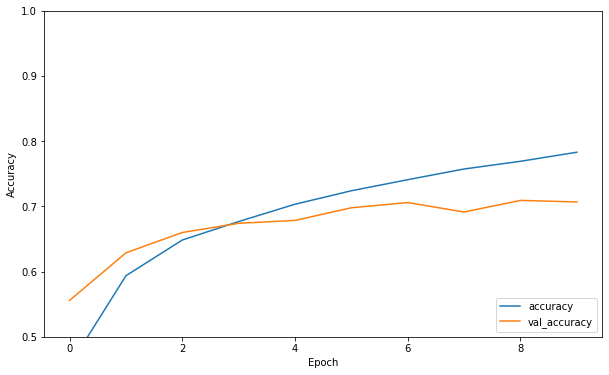

In [48]:
#Evaluate the model
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5,1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose = 2)

In [50]:
print('Test Accuracy: ', test_acc)
print('Test Loss: ', test_loss)

Test Accuracy:  0.7067
Test Loss:  0.8716748604774475


# Using TensorBoard in Notebooks

In [52]:
#Loading the Tensorboard notebook extension
%load_ext tensorboard
import datetime


#Download the FashionMNIST dataset and scale it
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [53]:
#Create a model
def create_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28,28)),
        tf.keras.layers.Dense(512, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation = 'softmax')
    ])

In [57]:
#Training the model using keras and Tensorboard callback

def train_model():
    model = create_model()
    model.compile(optimizer = 'adam',
                 loss = 'sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    logdir = os.path.join('logss', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    
    model.fit(x = x_train, y = y_train, epochs=5, validation_data=(x_test,y_test),
             callbacks = [tensorboard_callback])
        
train_model()

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 17s 275us/sample - loss: 0.4959 - accuracy: 0.8226 - val_loss: 0.4148 - val_accuracy: 0.8506
Epoch 2/5
60000/60000 [==============================] - 13s 221us/sample - loss: 0.3816 - accuracy: 0.8610 - val_loss: 0.3834 - val_accuracy: 0.8619
Epoch 3/5
60000/60000 [==============================] - 14s 232us/sample - loss: 0.3498 - accuracy: 0.8712 - val_loss: 0.3716 - val_accuracy: 0.8678
Epoch 4/5
60000/60000 [==============================] - 15s 248us/sample - loss: 0.3285 - accuracy: 0.8796 - val_loss: 0.3720 - val_accuracy: 0.8643
Epoch 5/5
60000/60000 [==============================] - 16s 259us/sample - loss: 0.3129 - accuracy: 0.8840 - val_loss: 0.3503 - val_accuracy: 0.8747


In [70]:
# from tensorboard import notebook
# notebook.configure(host="website-address-needed")

# %tensorboard --logdir ./logss

In [71]:
#View open TensorBoard instances
from tensorboard import notebook
notebook.list()

Known TensorBoard instances:
  - port 6006: logdir checkpoint_prefex (started 5 days, 21:44:47 ago; pid 12384)
  - port 6006: logdir {logss} (started 0:16:43 ago; pid 20056)
  - port 6006: logdir logss (started 0:27:29 ago; pid 7008)
